In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import netCDF4 as cdf
import h5py as hdf
from tm5tools import globarea
import numpy as np
import matplotlib.pyplot  as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
#from mpl_toolkits.basemap import Basemap
from maptools import select_map
import csv
import sys
from copy import copy
import pandas as pd
import os,sys
from calendar import monthrange,isleap

In [3]:
clrs_casa = ['darkslateblue',
             'darkgreen',   
             'lawngreen']

indir = ['/Users/botia/mnt/promise/CO2/carbontracker/input/Fires/CASA-GFED4_original_files/']


5.1006447191e+14


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


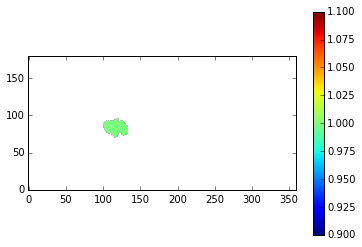

In [4]:
fac= 12./1.e15 #gC/m2/month -> PgC/m2/yr

mf = cdf.Dataset('/Users/botia/daily_fires/amazon_mask.nc')

# the mask has a 1x1 degree resolution
mask = mf.variables['regionmask'][:]
mask = np.ma.masked_where(mask==0,mask)
glarea = globarea(im=360,jm=180)

print glarea.sum()

imshow(mask)
colorbar()
plt.gca().invert_yaxis()

In [5]:
biome_name_list = ['Agriculture', 'Deforestation', 'Savanna']

In [6]:
infile = '/Users/botia/mnt/promise/CO2/carbontracker/input/Fires/CASA-GFED4_original_files/GFED4.1s_2006.hdf5'

In [14]:
####################### Reading the original files from Van der Werf ###########################

agri_yearly = []
defo_yearly = []
sava_yearly = []
glob_yearly = []
amazon_yearly = []

g_agri_yearly = []
g_borf_yearly = []
g_defo_yearly = []
g_peat_yearly = []
g_sava_yearly = []
g_temf_yearly = []

for y in range(2010,2016):
    print y
    infile = '/Users/botia/mnt/promise/CO2/carbontracker/input/Fires/CASA-GFED4_original_files/GFED4.1s_%i.hdf5'%(y)
    #infile = os.path.join(indir,'GFED4.1s_%i.hdf5'%y)
    f = hdf.File(infile,'r')
    keys = f.keys()
    regions = np.array(f.get('ancill/basis_regions'))[::-1]
    area = np.array(f.get('ancill/grid_cell_area'))[::-1]
        
    allmonths_agri_amazon = []
    allmonths_defo_amazon = []
    allmonths_sava_amazon = []
    allmonths_fire_global = []
    allmonths_fire_amazon = []
    allmonths_peat_amazon = []
    
    allmonths_defo_emi = []
    allmonths_agri_emi = []
    allmonths_borf_emi = []
    allmonths_peat_emi = []
    allmonths_sava_emi = []
    allmonths_temf_emi = []
    
    for m in range(12):
        #print m+1,y
        # All in 720X1440 0.25                                                     # Percentage: Unitless
        part = (np.array(f.get('emissions/%02d/partitioning/'%(m+1))))[::-1]       # Total partitioning 
        agri = (np.array(f.get('emissions/%02d/partitioning/C_AGRI'%(m+1))))[::-1] # agricultural waste burning
        borf = (np.array(f.get('emissions/%02d/partitioning/C_BORF'%(m+1))))[::-1] # boreal forest fires
        defo = (np.array(f.get('emissions/%02d/partitioning/C_DEFO'%(m+1))))[::-1] # tropical forest fires
        peat = (np.array(f.get('emissions/%02d/partitioning/C_PEAT'%(m+1))))[::-1] # peat fires
        sava = (np.array(f.get('emissions/%02d/partitioning/C_SAVA'%(m+1))))[::-1] # savanna, grassland and shrubland
        temf = (np.array(f.get('emissions/%02d/partitioning/C_TEMF'%(m+1))))[::-1] # temperate forest fires
        
        # multiplying emissions to get PgC/yr
        monthly_emis_orig = (np.array(f.get('emissions/%02d/C'%(m+1))))[::-1]*area*fac
        
        daysinmonth = monthrange(y,m+1)[1]
        
        # Multiplying the percentage of each biome with the total monthly emissions
        # Check if there is a problem with this multiplication
        agri_emi = agri*monthly_emis_orig 
        borf_emi = borf*monthly_emis_orig 
        defo_emi = defo*monthly_emis_orig 
        peat_emi = peat*monthly_emis_orig 
        sava_emi = sava*monthly_emis_orig 
        temf_emi = temf*monthly_emis_orig 
                     
        monthly_emis_1x1=np.zeros((180,360),float)    
        agri_emi_1x1=np.zeros((180,360),float)
        borf_emi_1x1=np.zeros((180,360),float)
        defo_emi_1x1=np.zeros((180,360),float)
        peat_emi_1x1=np.zeros((180,360),float)        
        sava_emi_1x1=np.zeros((180,360),float)
        temf_emi_1x1=np.zeros((180,360),float)
        
        # Changing to 1x1 degree
        for i in range(180):
            for j in range(360):
                monthly_emis_1x1[i,j] = monthly_emis_orig[i+i*3:(i+1)*4,j+j*3:(j+1)*4].sum()
                agri_emi_1x1[i,j] = agri_emi[i+i*3:(i+1)*4,j+j*3:(j+1)*4].sum()
                borf_emi_1x1[i,j] = borf_emi[i+i*3:(i+1)*4,j+j*3:(j+1)*4].sum()
                defo_emi_1x1[i,j] = defo_emi[i+i*3:(i+1)*4,j+j*3:(j+1)*4].sum()
                peat_emi_1x1[i,j] = peat_emi[i+i*3:(i+1)*4,j+j*3:(j+1)*4].sum()
                sava_emi_1x1[i,j] = sava_emi[i+i*3:(i+1)*4,j+j*3:(j+1)*4].sum()
                temf_emi_1x1[i,j] = temf_emi[i+i*3:(i+1)*4,j+j*3:(j+1)*4].sum()
                            
        allmonths_fire_global.append((monthly_emis_1x1).sum())
        allmonths_fire_amazon.append((monthly_emis_1x1*mask).sum()) # Amazon from global
        
        # Amazon's emissions partitioned
        allmonths_agri_amazon.append((agri_emi_1x1*mask).sum())
        allmonths_defo_amazon.append((defo_emi_1x1*mask).sum())
        allmonths_peat_amazon.append((peat_emi_1x1*mask).sum())        
        allmonths_sava_amazon.append((sava_emi_1x1*mask).sum())
        
        # Global emissions partitioned
        allmonths_agri_emi.append((agri_emi_1x1).sum())
        allmonths_borf_emi.append((borf_emi_1x1).sum())
        allmonths_defo_emi.append((defo_emi_1x1).sum())
        allmonths_peat_emi.append((peat_emi_1x1).sum())        
        allmonths_sava_emi.append((sava_emi_1x1).sum())
        allmonths_temf_emi.append((temf_emi_1x1).sum())
        
    g_agri = mean(allmonths_agri_emi)*1000
    g_borf = mean(allmonths_borf_emi)*1000
    g_defo = mean(allmonths_defo_emi)*1000
    g_peat = mean(allmonths_peat_emi)*1000
    g_sava = mean(allmonths_sava_emi)*1000
    g_temf = mean(allmonths_temf_emi)*1000
    
    amazon = mean(allmonths_fire_amazon)*1000

    glob = mean(allmonths_fire_global)*1000  
    agri = mean(allmonths_agri_amazon)*1000
    defo = mean(allmonths_defo_amazon)*1000
    sava = mean(allmonths_sava_amazon)*1000
    
    amazon_yearly.append(amazon)
    agri_yearly.append(agri)
    defo_yearly.append(defo)
    sava_yearly.append(sava)
    
    glob_yearly.append(glob)
    g_agri_yearly.append(g_agri)
    g_borf_yearly.append(g_borf)
    g_defo_yearly.append(g_defo)
    g_peat_yearly.append(g_peat)
    g_sava_yearly.append(g_sava)
    g_temf_yearly.append(g_temf)
        
    f.close() 

2010
2011
2012
2013
2014
2015


In [60]:
times = pd.Series([2010,2011,2012,2013,2014,2015])
data = np.zeros((6,3),float)
timess = [2010,2011,2012,2013,2014,2015]
print agri_yearly
print defo_yearly
print sava_yearly
print amazon_yearly

dataframe_per = pd.DataFrame(data, index=times, columns = ('Agriculture','Deforestation','Savanna') )
for i in range(len(timess)):
    agri = (agri_yearly[i]/amazon_yearly[i])*100
    defo = (defo_yearly[i]/amazon_yearly[i])*100
    sava = (sava_yearly[i]/amazon_yearly[i])*100
    per = [agri, defo, sava]
    for j in range(len(per)):
        dataframe_per.iloc[i,j] = per[j]
dataframe_per
dataframe_per.to_pickle('yearly_percentages')

[3.6423857093668133, 2.5820942495424029, 4.6293543016808769, 3.6709199294839103, 3.7119314733805218, 4.6006882847815511]
[298.66688771385458, 47.114907254562389, 99.546910363869756, 31.368462708239043, 80.415715501231944, 116.80059270114877]
[164.47086613057138, 45.745326188638394, 91.832260821147329, 47.442652685983433, 65.736440865921494, 77.491822775037633]
[466.78014020945113, 95.442327069055935, 196.00852646412412, 82.482035086885716, 149.86408774343829, 198.89310317464748]
6


In [61]:
times = pd.Series([2010,2011,2012,2013,2014,2015])
data = np.zeros((6,4),float)
#df = pd.DataFrame(data, index=times, columns = ('Agriculture','Deforestation','Savanna','Total'))

all_biomes = [agri_yearly,defo_yearly,sava_yearly,amazon_yearly]

for i in range(len(all_biomes)):
    iterator = i
    dataframe = pd.DataFrame(data, index=times, columns = ('Agriculture','Deforestation','Savanna','Total'))
    
    biomes = all_biomes[i]
    col = ['Agriculture','Deforestation','Savanna','Total']
    dataframe.loc[:,col[i]] = (biomes)
    
dataframe
dataframe.to_pickle('yearly_emissions')

In [8]:
################################################### Read this before plotting ###############################################

df_yearly_per = pd.read_pickle('yearly_percentages')
df_yearly_em = pd.read_pickle('yearly_emissions')
df_yearly_em

,Agriculture,Deforestation,Savanna,Total
2010,3.642386,298.666888,164.470866,466.780140
2011,2.582094,47.114907,45.745326,95.442327
2012,4.629354,99.546910,91.832261,196.008526
2013,3.670920,31.368463,47.442653,82.482035
2014,3.711931,80.415716,65.736441,149.864088
2015,4.600688,116.800593,77.491823,198.893103


[22.837373948236074, 673.91347624290654, 492.71936946729966, 1189.4702197476026]
[1.9199618089708885, 56.656607711112464, 41.423430472420847] 99.9999999925


[None, None, None]

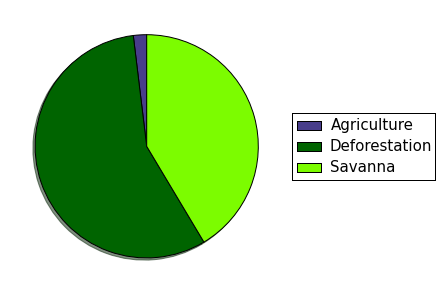

In [39]:
################################################# Merged year percentage ##################################################
fig = plt.figure(1,figsize=(5,5))

total = sum(amazon_yearly)
agri_total_per = sum(agri_yearly)/total*100
defo_total_per = sum(defo_yearly)/total*100
sava_total_per = sum(sava_yearly)/total*100

totals = [sum(agri_yearly),sum(defo_yearly),sum(sava_yearly), total]
percentages = [(sum(agri_yearly)/total)*100,(sum(defo_yearly)/total)*100,(sum(sava_yearly)/total)*100]

print totals
print percentages, sum(percentages)

pie_list = [agri_total_per, defo_total_per, sava_total_per]
legenda = ['Agriculture', 'Deforestation', 'Savanna']

plt.pie(pie_list,colors=clrs_casa,startangle=90,shadow=True)
plt.legend(legenda,loc='center left',bbox_to_anchor=(1, 0.5)) 
leg = plt.gca().get_legend()
ltext  = leg.get_texts()
plt.setp(ltext, fontsize='15')  

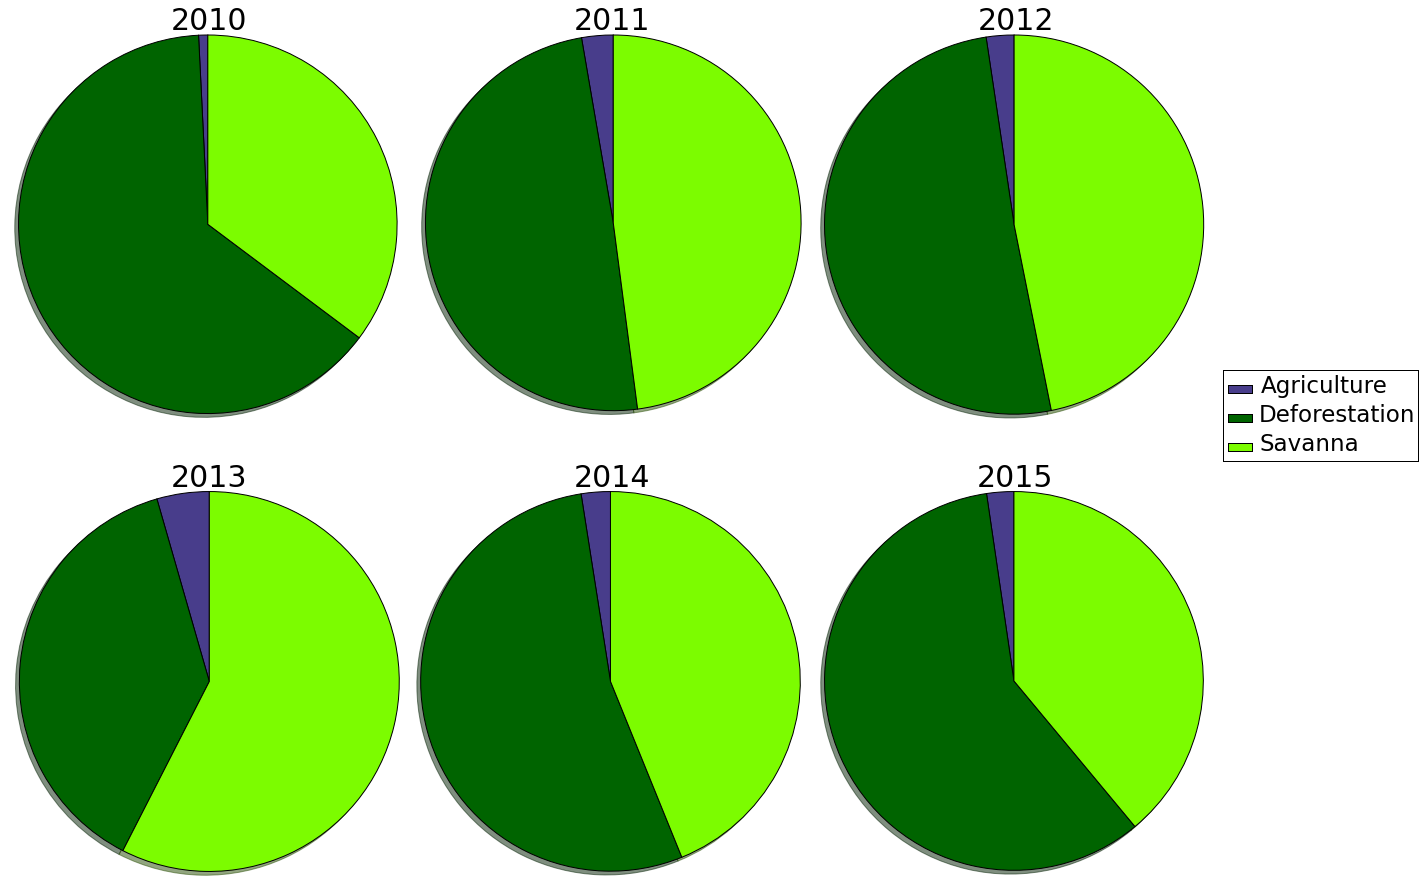

In [85]:
fig = plt.figure(1,figsize=(28,15))
fig.subplots_adjust(left=0,right=0.6,wspace=0)
ax1 = plt.subplot(231)
ax1.set_title('2010',fontsize=30)
ax2 = plt.subplot(232)
ax2.set_title('2011',fontsize=30)
ax3 = plt.subplot(233)
ax3.set_title('2012',fontsize=30)
ax4 = plt.subplot(234)
ax4.set_title('2013',fontsize=30)
ax5 = plt.subplot(235)
ax5.set_title('2014',fontsize=30)
ax6 = plt.subplot(236)
ax6.set_title('2015',fontsize=30)

############# Remember to change the name for 
############# the fireproduct that wants to be plotted
legenda = ['Agriculture', 'Deforestation', 'Savanna']

for i in range(6):
    year_perc = (df_yearly_per.iloc[[i],:]).values
    year_perc = year_perc.T
    if i == 0:
        ax1.pie(year_perc,colors=clrs_casa,startangle=90,shadow=True)
    if i == 1:
        ax2.pie(year_perc,colors=clrs_casa,startangle=90,shadow=True)
    if i == 2:
        ax3.pie(year_perc,colors=clrs_casa,startangle=90,shadow=True)
    if i == 3:
        ax4.pie(year_perc,colors=clrs_casa,startangle=90,shadow=True)
    if i == 4:
        ax5.pie(year_perc,colors=clrs_casa,startangle=90,shadow=True)
    if i == 5:
        ax6.pie(year_perc,colors=clrs_casa,startangle=90,shadow=True)
    
ax1.axis('equal') 
ax2.axis('equal') 
ax3.axis('equal')
ax4.axis('equal')
ax4.axis('equal')
ax5.axis('equal')
ax6.axis('equal')

ax6.legend(legenda[:],loc='center left', bbox_to_anchor=(1, 1.2))
leg = plt.gca().get_legend()
ltext  = leg.get_texts()
plt.setp(ltext, fontsize='23') 
fig.savefig('CASA_GFED4.png')
plt.show()

In [146]:
df_yearly = df_yearly_em/1000
print df_yearly
agricul = (df_yearly.iloc[:,[0]])
defores = (df_yearly.iloc[:,[1]])
savan = (df_yearly.iloc[:,[2]])

      Agriculture  Deforestation   Savanna     Total
2010     0.003642       0.298667  0.164471  0.466780
2011     0.002582       0.047115  0.045745  0.095442
2012     0.004629       0.099547  0.091832  0.196009
2013     0.003671       0.031368  0.047443  0.082482
2014     0.003712       0.080416  0.065736  0.149864
2015     0.004601       0.116801  0.077492  0.198893


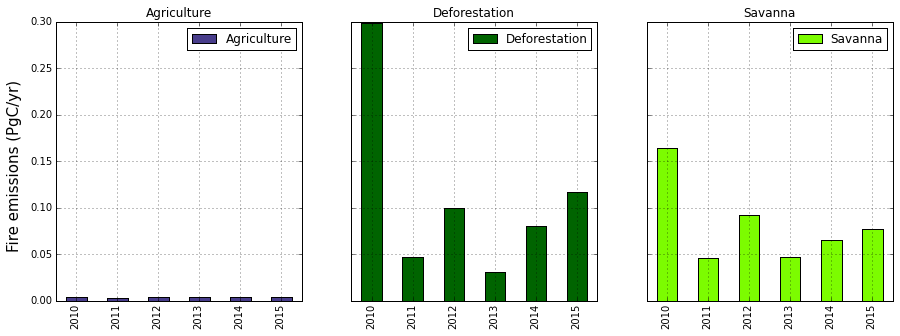

In [156]:
############################################## Yearly emissions #############################################################

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15,5))
fig.text(0.08, 0.5, 'Fire emissions (PgC/yr)', va='center', rotation='vertical',fontsize=15)

ax1 = agricul.plot(kind='bar',title='Agriculture',color='darkslateblue',ax=axes[0])
ax2 = defores.plot(kind='bar',title='Deforestation',color='darkgreen',ax=axes[1])  #, ax=axes[0,1], legend=False)
ax3 = savan.plot(kind='bar', title='Savanna',color='lawngreen',ax=axes[2])         #,ax=axes[0,2], legend=False)

#leg = plt.gca().get_legend()
#ltext  = leg.get_texts()
#plt.setp(ltext, fontsize='23') 
#plt.tight_layout()
fig.savefig('Fire emissions for Original Biomes of GFED4.png')#, bbox_extra_artists=(leg,), bbox_inches='tight')
plt.show() 

<function matplotlib.pyplot.show>

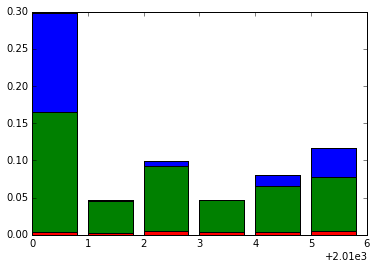

In [145]:
agricul = (df_yearly.iloc[:,[0]]).values
defores = (df_yearly.iloc[:,[1]]).values
savan = (df_yearly.iloc[:,[2]]).values

x= range (2010,2016)

plt.bar(x,defores, color='b')
plt.bar(x,savan, color='g')
plt.bar(x,agricul, color='r')
plt.show

#plt.bar(X, A, color = 'b')
#plt.bar(X, B, color = 'r', bottom = A)
#plt.show()